In [1]:
# -*- pecanns -*-
"""
Author: Shamsulhaq Basir
Date  : June 20, 2022
"""
import argparse
import time
import os
import torch
import torch.nn as nn
import numpy as np
from numpy import vectorize
from tqdm import tqdm

from torch.optim import LBFGS,Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.set_default_dtype(torch.float64)
dtype  = torch.float64

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
import matplotlib as mpl
from matplotlib import ticker

In [2]:
class ConventBlock(nn.Module):
    def __init__(self,in_N,out_N):
        super(ConventBlock, self).__init__()
        self.Ls  = None
        self.net = nn.Sequential(nn.Linear(in_N,out_N),nn.Tanh()) 
    def forward(self, x):
        out = self.net(x)
        return out 
    
    
class Network(torch.nn.Module):
    def __init__(self,layers,**kwargs):
        super(Network,self).__init__()
        self.mu    = kwargs["mean"]
        self.stdev = kwargs["stdev"]
        _layers = [] 
        for i in range(0,len(layers)-2):
            _layers.append(ConventBlock(layers[i],layers[i+1]))
        _layers.append(torch.nn.Linear(layers[-2],layers[-1]))
        self.net = torch.nn.Sequential(*_layers)
        
    def forward(self,x,t):
        data = torch.cat((x,t),dim=1);
        # normalize the input
        data = (data - self.mu)/self.stdev
        out  = self.net(data)
        u    = out[:,0].reshape(-1,1)
        v    = out[:,1].reshape(-1,1)
        p    = out[:,2].reshape(-1,1)
        w    = out[:,3].reshape(-1,1)
        return u,v,p,w
        
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)
        nn.init.zeros_(m.bias)   

In [3]:
def pde_opt(model,x,y):
    
    u,v,p,w = model(x,y)
    
    px,py   = torch.autograd.grad(p.sum(),(x,y),create_graph=True)
    wx,wy   = torch.autograd.grad(w.sum(),(x,y),create_graph=True)
    ux,uy   = torch.autograd.grad(u.sum(),(x,y),create_graph=True)
    vx,vy   = torch.autograd.grad(v.sum(),(x,y),create_graph=True)
    
    physics_loss    = (u * ux + v * uy + px + 0.01 * wy).pow(2) + \
                      (u * vx + v * vy + py - 0.01 * wx).pow(2)
    
    divergence_loss = (ux + vy).pow(2)
    vorticity_loss  = (w + uy - vx).pow(2)
    return physics_loss,divergence_loss,vorticity_loss

In [4]:
def velocity_exact(x,y):
    if y == 1.0 :
        ue,ve = 1.0, 0.0
    else:
        ue,ve = 0.0, 0.0
    return ue,ve

In [5]:
def boundary_opt(model,x,y,ue,ve):
    u,v,_,_  = model(x,y)
    boundary_res = (u-ue).pow(2) + (v-ve).pow(2)
    return boundary_res

In [6]:
def pressure_opt(model,x_p,y_p):
    _,_,p,_      = model(x_p,y_p)
    pressure_res = (p).pow(2) 
    return pressure_res

In [7]:
def sample_collocation_points(domain,batch_size):
    dim      = domain.shape[0]
    soboleng = torch.quasirandom.SobolEngine(dimension=dim,scramble=True)
    data     = soboleng.draw(batch_size,dtype=dtype)*(domain[1] - domain[0]) + domain[0]
    x        = data[:,0][:,None]
    y        = data[:,1][:,None]
    return x,y

In [8]:
def sample_boundary_points(domain,batch_size):
    
    x_min =domain[0][0] 
    x_max =domain[1][0] 
    
    y_min =domain[0][1] 
    y_max =domain[1][1]
    
    
    soboleng = torch.quasirandom.SobolEngine(dimension=1,scramble=True)
    
    x_top   = soboleng.draw(batch_size,dtype=dtype)*(x_max - x_min) + x_min
    y_top   = torch.full_like(x_top,y_max)
    
    y_right = soboleng.draw(batch_size,dtype=dtype)*(y_max - y_min) + y_min
    x_right = torch.full_like(y_right,x_max)
    
    x_bottom = soboleng.draw(batch_size,dtype=dtype)*(x_max - x_min) + x_min
    y_bottom = torch.full_like(x_bottom,y_min)
    
    y_left = soboleng.draw(batch_size,dtype=dtype)*(y_max - y_min) + y_min
    x_left = torch.full_like(y_left,x_min)
    
    x = torch.cat((x_top,x_right,x_bottom,x_left),dim=0)
    y = torch.cat((y_top,y_right,y_bottom,y_left),dim=0)
    
    return x,y

In [9]:
domain   = np.array([[0.,0.],[1.0, 1.0]])
kwargs ={"mean":torch.tensor([[0.5, 0.5]]), "stdev":torch.tensor([[0.2887, 0.2887]])}   

layers = [2,20,20,20,20,20,20,4]
model  = Network(layers,**kwargs)
model.apply(init_weights)

optimizer   = LBFGS(model.parameters(),line_search_fn='strong_wolfe')
if type(optimizer).__name__ in ['Adam']:
    scheduler   = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.9,patience=100)

print(model)
print(model.mu.shape)
print(model.stdev.shape)

Network(
  (net): Sequential(
    (0): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=2, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (1): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (2): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (3): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (4): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (5): ConventBlock(
      (net): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Tanh()
      )
    )
    (6): Linear(in_features=20, out_features=4, bias=True)
  )
)
torch.Size([1, 2])
torch.Size(

In [10]:
# sampling collocation points in the domain
x_dm,y_dm  = sample_collocation_points(domain,2500)
x_dm       = x_dm.requires_grad_(True)
y_dm       = y_dm.requires_grad_(True)

x_bc,y_bc = sample_boundary_points(domain,128)
ue,ve     = vectorize(velocity_exact)(x_bc,y_bc)
ue        = torch.from_numpy(ue)
ve        = torch.from_numpy(ve)

x_p,y_p   = torch.tensor([[0.0]]),torch.tensor([[0.0]])

In [11]:
lambda_vorticity  = torch.ones_like(x_dm)
lambda_divergence = torch.ones_like(x_dm)
lambda_boundary   = torch.ones_like(x_bc)
lambda_pressure   = torch.ones_like(x_p)


vi_vorticity      = torch.zeros_like(x_dm)
vi_divergence     = torch.zeros_like(x_dm)
vi_boundary       = torch.zeros_like(x_bc)
vi_pressure       = torch.zeros_like(x_p)


moment          = 0.9
lr              = 1e-2

epochs          = 20000

In [12]:
for epoch in tqdm(range(1,epochs+1)):

    def closure():
        if torch.is_grad_enabled():
            optimizer.zero_grad()

        physics_res,divergence_res,vorticity_res = pde_opt(model,x_dm,y_dm)
        
        # physics loss
        physics_loss = physics_res.sum()
        
        # divergence loss
        divergence_loss = (lambda_divergence * divergence_res).sum()
        
        
        # vorticity loss
        vorticity_loss  = (lambda_vorticity * vorticity_res).sum()
    
        
        # boundary loss 
        boundary_res  = boundary_opt(model,x_bc,y_bc,ue,ve)
        
        
        boundary_loss   = (lambda_boundary * boundary_res).sum()
        
        
        # pressure constraint
        pressure_res  = pressure_opt(model,x_p,y_p)
        
        
        pressure_loss = (lambda_pressure * pressure_res).sum()
        
        
        # total loss
        loss      = physics_loss + divergence_loss  + vorticity_loss + boundary_loss + pressure_loss
            
        if loss.requires_grad:
            loss.backward()
        return loss
    
    
    def _closure():
        physics_res,divergence_res,vorticity_res = pde_opt(model,x_dm,y_dm)
        
        boundary_res  = boundary_opt(model,x_bc,y_bc,ue,ve)
        
        pressure_res  = pressure_opt(model,x_p,y_p)
        
        return physics_res,divergence_res,vorticity_res,boundary_res,pressure_res
    

    optimizer.step(closure)
    physics_res,divergence_res,vorticity_res,boundary_res,pressure_res = _closure()
    if type(optimizer).__name__ in ['Adam']:
        scheduler.step(physics_res.sum().item())
        
    with torch.no_grad():
        
        vi_divergence       = (1.0 - moment) * divergence_res.pow(2) + moment * vi_divergence
        vi_vorticity        = (1.0 - moment) * vorticity_res.pow(2)  + moment * vi_vorticity
        vi_boundary         = (1.0 - moment) * boundary_res.pow(2)   + moment * vi_boundary
        vi_pressure         = (1.0 - moment) * pressure_res.pow(2)   + moment * vi_pressure
        
        
        lambda_divergence  += lr / ( vi_divergence   + 1e-8).sqrt()   * divergence_res
        lambda_vorticity   += lr / ( vi_vorticity    + 1e-8).sqrt()   * vorticity_res
        lambda_boundary    += lr / ( vi_boundary     + 1e-8).sqrt()   * boundary_res
        lambda_pressure    += lr / ( vi_pressure     + 1e-8).sqrt()   * pressure_res
        if epoch % 1000 == 0:
            torch.save(model.state_dict(),f"models/Navier_Stokes_Flow_{epoch}.pt")

100%|██████████| 20000/20000 [3:40:17<00:00,  1.51it/s]  


In [13]:
torch.save(model.state_dict(),"models/Navier_Stokes_Flow.pt")

In [14]:
# https://joseph-long.com/writing/colorbars/
def colorbar(mappable,min_val,max_val,limit):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    ticks = np.linspace(min_val, max_val, 4, endpoint=True)
    cbar = fig.colorbar(mappable, cax=cax,ticks=ticks)
    cbar.formatter.set_powerlimits((limit, limit))
    plt.sca(last_axes)
    return cbar

params = {
    'text.latex.preamble': '\\usepackage{gensymb}',
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels
    'axes.titlesize': 14,
    'font.size'     : 14, 
    'legend.fontsize': 14, 
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex': False,
    'figure.figsize': [4, 4],
    'font.family': 'serif',
}
plt.rcParams.update(params)
cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
cmap = plt.cm.get_cmap(cmap_list[8]).reversed()

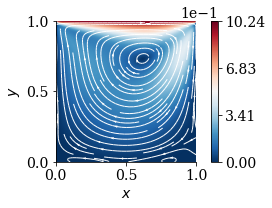

In [15]:
fig = plt.figure()
gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0,0])

x = torch.linspace(0,1,256)
y = torch.linspace(0,1,256)

x,y = torch.meshgrid(x,y,indexing='xy')

up,vp,_,_ = model(x.reshape(-1,1),y.reshape(-1,1))

up = up.reshape(x.shape)
vp = vp.reshape(x.shape)

velocity = (up.detach().pow(2) + vp.detach().pow(2)).sqrt()

pimg=plt.pcolormesh(x.numpy(),y.numpy(),
                    velocity,cmap=cmap,
                    shading='gouraud',
                    vmin=torch.amin(velocity),
                    vmax=torch.amax(velocity))

colorbar(pimg,min_val = torch.amin(velocity),max_val= torch.amax(velocity),limit=-1)



x = torch.linspace(0,1,128)
y = torch.linspace(0,1,128)

x,y = torch.meshgrid(x,y,indexing='xy')
up,vp,_,_ = model(x.reshape(-1,1),y.reshape(-1,1))

up = up.reshape(x.shape)
vp = vp.reshape(x.shape)

plt.streamplot(x.numpy(),y.numpy(),
                  up.detach().numpy(),
                  vp.detach().numpy(),
                  density=1,
                  arrowsize=0.3,
                  arrowstyle='->',
                  color='w',
                  linewidth=1,
                  cmap=cmap)


ax.axis('scaled')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xticks(np.linspace(0,1,3))
ax.set_yticks(np.linspace(0,1,3))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
plt.savefig('figures/predicted_ns_velocity_field.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

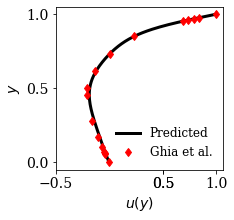

In [16]:
fig = plt.figure(figsize=(3,3))
gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0,0])

y = []
u = []
with open('ghiau.txt') as f:
    while True:
        line = f.readline()
        if not line: 
            break
        line = line.strip()
        y.append(float(line.split()[0]))
        u.append(float(line.split()[1]))
        
y = torch.tensor(y).reshape(-1,1)
x = torch.full_like(y,0.5)
u = torch.tensor(u).reshape(-1,1)

# prediction from the model
y_ = torch.linspace(0,1,256)[:,None]
x_ = torch.full_like(y_,0.5)
up,_,_,_ = model(x_,y_)

ax.plot(up.detach(),y_,"k",linewidth=3,label='Predicted')
ax.plot(u,y,'dr',linewidth=3,label="Ghia et al.")
ax.set_xlabel('$u(y)$')
ax.set_ylabel('$y$')
ax.set_yticks([0,0.5,1])
ax.set_xticks([-0.5,0.5,0.5,1])
ax.legend(frameon=False,fontsize=12)
plt.savefig('figures/verification_ns_horizontal_velocity.png',bbox_inches='tight', pad_inches=0.1)
plt.show()

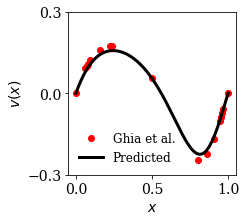

In [19]:
fig = plt.figure(figsize=(3,3))
gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0,0])


x = []
v = []
with open('ghiav.txt') as f:
    while True:
        line = f.readline()
        if not line: 
            break
        line = line.strip()
        x.append(float(line.split()[0]))
        v.append(float(line.split()[1]))
        
x = torch.tensor(x)
v = torch.tensor(v)

ax.plot(x,v,'or',label='Ghia et al.')

# model
x = torch.linspace(0,1,256)[:,None]
y = torch.full_like(x,0.5)
_,vp,_,_ = model(x,y)

ax.plot(x,vp.detach(),"k",linewidth=3,label="Predicted")
ax.set_xlabel('$x$')
ax.set_ylabel('$v(x)$')
ax.set_yticks([-0.3,0,0.3])
ax.set_xticks([-0,0.5,1.0])
ax.legend(frameon=False,fontsize=12)
plt.savefig('figures/verification_ns_vertical_velocity.png',bbox_inches='tight', pad_inches=0.1)
plt.show()